In [1]:
!python --version

Python 3.6.6 :: Anaconda, Inc.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# Any results you write to the current directory are saved as output.

/kaggle/input/seattle/listings.csv
/kaggle/input/seattle/reviews.csv
/kaggle/input/seattle/calendar.csv


In [3]:
print(np.__version__)
print(sns.__version__)
print(pd.__version__)

1.18.1
0.9.0
0.25.3


In [4]:
listings_df = pd.read_csv('/kaggle/input/seattle/listings.csv')
calendar_df = pd.read_csv('/kaggle/input/seattle/calendar.csv')

In [5]:
print(listings_df.shape)
print(listings_df.info())
print(listings_df.head())
print(calendar_df.shape)
print(calendar_df.info())
print(calendar_df.head())

(3818, 92)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url               

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB
None
   listing_id        date available   price
0      241032  2016-01-04         t  $85.00
1      241032  2016-01-05         t  $85.00
2      241032  2016-01-06         f     NaN
3      241032  2016-01-07         f     NaN
4      241032  2016-01-08         f     NaN


In [6]:
listings_df_new = listings_df[['id','host_id', 'price', 'city', 'neighbourhood'
                                                      , 'host_since', 'host_is_superhost'
                                                      , 'room_type', 'bed_type', 'beds', 'bedrooms', 'bathrooms'
                                                      , 'minimum_nights', 'cancellation_policy', 'instant_bookable']]

In [7]:
listing_calendar_df = listings_df_new.merge(calendar_df, left_on = 'id', right_on = 'listing_id', suffixes = ['_listing', '_calendar'])

In [8]:
listing_calendar_v2_df = listings_df_new.merge(calendar_df, left_on = 'id', right_on = 'listing_id', suffixes = ['_listing', '_calendar'])

In [9]:
listing_calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1393570 entries, 0 to 1393569
Data columns (total 19 columns):
id                     1393570 non-null int64
host_id                1393570 non-null int64
price_listing          1393570 non-null object
city                   1393570 non-null object
neighbourhood          1241730 non-null object
host_since             1392840 non-null object
host_is_superhost      1392840 non-null object
room_type              1393570 non-null object
bed_type               1393570 non-null object
beds                   1393205 non-null float64
bedrooms               1391380 non-null float64
bathrooms              1387730 non-null float64
minimum_nights         1393570 non-null int64
cancellation_policy    1393570 non-null object
instant_bookable       1393570 non-null object
listing_id             1393570 non-null int64
date                   1393570 non-null object
available              1393570 non-null object
price_calendar         934542 non-null obj

In [10]:
listing_calendar_df = listing_calendar_df.drop(['id', 'listing_id'], axis = 1)
listing_calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1393570 entries, 0 to 1393569
Data columns (total 17 columns):
host_id                1393570 non-null int64
price_listing          1393570 non-null object
city                   1393570 non-null object
neighbourhood          1241730 non-null object
host_since             1392840 non-null object
host_is_superhost      1392840 non-null object
room_type              1393570 non-null object
bed_type               1393570 non-null object
beds                   1393205 non-null float64
bedrooms               1391380 non-null float64
bathrooms              1387730 non-null float64
minimum_nights         1393570 non-null int64
cancellation_policy    1393570 non-null object
instant_bookable       1393570 non-null object
date                   1393570 non-null object
available              1393570 non-null object
price_calendar         934542 non-null object
dtypes: float64(3), int64(2), object(12)
memory usage: 191.4+ MB


In [11]:
listing_calendar_df.isnull().sum()

host_id                     0
price_listing               0
city                        0
neighbourhood          151840
host_since                730
host_is_superhost         730
room_type                   0
bed_type                    0
beds                      365
bedrooms                 2190
bathrooms                5840
minimum_nights              0
cancellation_policy         0
instant_bookable            0
date                        0
available                   0
price_calendar         459028
dtype: int64

# Fill Missing Values

A few columns contains missing values. Instead of drop all missing values, which will cause troubles for further analysis, I will impute the missing values. There are many common methods for missing value imputation. However, after review the dataset, I think the common methods are not the best options for this datasest. For example, host_is_superhost column contains 730 missing values. The superhost is a feature that AirBnB gave to the host who provided excellent services and had been approved by the visitors every 3 months. This is a flag that provide by the AirBnB. If a host doesn't have the value of is the superhost that highly represents this host is not superhost. Meanwhile, the records that don't have superhost data, don't have the host_since data either. I assume these records are from new hosts. Therefore, using the 'f' value to fillin all the missing values in host_is_superhost column instead of using common missing value imputation is more properity. This logic will apply to other missing value imputation. Using the values that meet the situation of the real business rather than the common mean, median or mode imputation.

In [12]:
listing_calendar_df.loc[(listing_calendar_df['city'] == '西雅图') |(listing_calendar_df['city'] == 'seattle')|(listing_calendar_df['city'] == 'Seattle '), 'city'] = 'Seattle'

In [13]:
listing_calendar_df.loc[listing_calendar_df.neighbourhood.isnull(), 'neighbourhood'] = listing_calendar_df.loc[listing_calendar_df.neighbourhood.isnull(), 'city']

In [14]:
listing_calendar_df.loc[listing_calendar_df.host_is_superhost.isnull(), 'host_is_superhost'] = 'f'

In [15]:
listing_calendar_df.loc[listing_calendar_df.host_since.isnull(), ].groupby('host_id').date.agg('min')
listing_calendar_df.loc[listing_calendar_df.host_since.isnull(), 'host_since'] = '2016-01-04'

In [16]:
listing_calendar_df.loc[listing_calendar_df.price_calendar.isnull() > 0, "price_calendar"] = listing_calendar_df.loc[listing_calendar_df.price_calendar.isnull() > 0, "price_listing"]

In [17]:
listing_calendar_df.loc[listing_calendar_df.price_calendar.isnull() > 0, "price_calendar"].isnull()

Series([], Name: price_calendar, dtype: bool)

In [18]:
listing_calendar_df.drop(['price_listing'], axis = 1)
listing_calendar_df = listing_calendar_df.rename(columns = {'price_calendar':'price'})
listing_calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1393570 entries, 0 to 1393569
Data columns (total 17 columns):
host_id                1393570 non-null int64
price_listing          1393570 non-null object
city                   1393570 non-null object
neighbourhood          1393570 non-null object
host_since             1393570 non-null object
host_is_superhost      1393570 non-null object
room_type              1393570 non-null object
bed_type               1393570 non-null object
beds                   1393205 non-null float64
bedrooms               1391380 non-null float64
bathrooms              1387730 non-null float64
minimum_nights         1393570 non-null int64
cancellation_policy    1393570 non-null object
instant_bookable       1393570 non-null object
date                   1393570 non-null object
available              1393570 non-null object
price                  1393570 non-null object
dtypes: float64(3), int64(2), object(12)
memory usage: 191.4+ MB


In [19]:
listing_calendar_df.loc[listing_calendar_df.bedrooms.isnull(), 'bedrooms'] = 0

In [20]:
listing_calendar_df.loc[listing_calendar_df.beds.isnull(), 'bed_type'].unique()
listing_calendar_df.loc[listing_calendar_df.beds.isnull(), 'beds'] = 1

In [21]:
listing_calendar_df.loc[listing_calendar_df.bathrooms.isnull(), 'bathrooms'] = 0

In [22]:
listing_calendar_df.isnull().sum()

host_id                0
price_listing          0
city                   0
neighbourhood          0
host_since             0
host_is_superhost      0
room_type              0
bed_type               0
beds                   0
bedrooms               0
bathrooms              0
minimum_nights         0
cancellation_policy    0
instant_bookable       0
date                   0
available              0
price                  0
dtype: int64

In [23]:
listing_calendar_df = listing_calendar_df.drop(['host_id', 'price_listing'], axis = 1)

# Convert data type

In [24]:
def data_conversion(df):
    '''
    INPUT: df - pandas dataframe you want to convert data type
    OUTPUT: df - a new dataframe that has the following characteristics:
    1. all the dates are datetime data type
    2. all the binary variables are bool type
    3. all the price variables are numeric
    '''
    for col in df.columns:
        if (df[col].dtype == 'O'):
            if (df[col].str.match("[1-2][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]").sum() > 0):
                df[col] = pd.to_datetime(df[col], format='%Y-%m-%d', errors='ignore')
            elif (list(df[col].unique()) == ['t', 'f'] or list(df[col].unique()) == ['f', 't']):
                bl_convert = {'t': True, 'f': False}
                df[col] = df[col].replace(bl_convert)
            elif (df[col].str.contains("\$", na=False).sum() > 0):
                df[col] = pd.to_numeric(df[col].str.replace('\$|\,', ''))
        else:
            continue
    return df

In [25]:
listing_calendar_df = data_conversion(listing_calendar_df)
listing_calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1393570 entries, 0 to 1393569
Data columns (total 15 columns):
city                   1393570 non-null object
neighbourhood          1393570 non-null object
host_since             1393570 non-null datetime64[ns]
host_is_superhost      1393570 non-null bool
room_type              1393570 non-null object
bed_type               1393570 non-null object
beds                   1393570 non-null float64
bedrooms               1393570 non-null float64
bathrooms              1393570 non-null float64
minimum_nights         1393570 non-null int64
cancellation_policy    1393570 non-null object
instant_bookable       1393570 non-null bool
date                   1393570 non-null datetime64[ns]
available              1393570 non-null bool
price                  1393570 non-null float64
dtypes: bool(3), datetime64[ns](2), float64(4), int64(1), object(5)
memory usage: 142.2+ MB


In [26]:
def groupby_agg(df, groupby, agg):
    '''
    INPUT: df - pandas dataframe you want to put into groupby aggregation
           groupby - variable or variable list needs to group by
           agg: dictionary of aggregation variable and aggregation function 
           or list of dictionaries of aggregation variable and aggregation function
    OUTPUT: df - an aggreated pandas dataframe with reseted index
    '''
    df = df.groupby(groupby, as_index = False).agg(agg)
    return df


# Word Clouds of Amenities

In [27]:
text = listings_df.amenities.str.replace('{|}|TV,|Internet,|"', "").str.split(r",").values

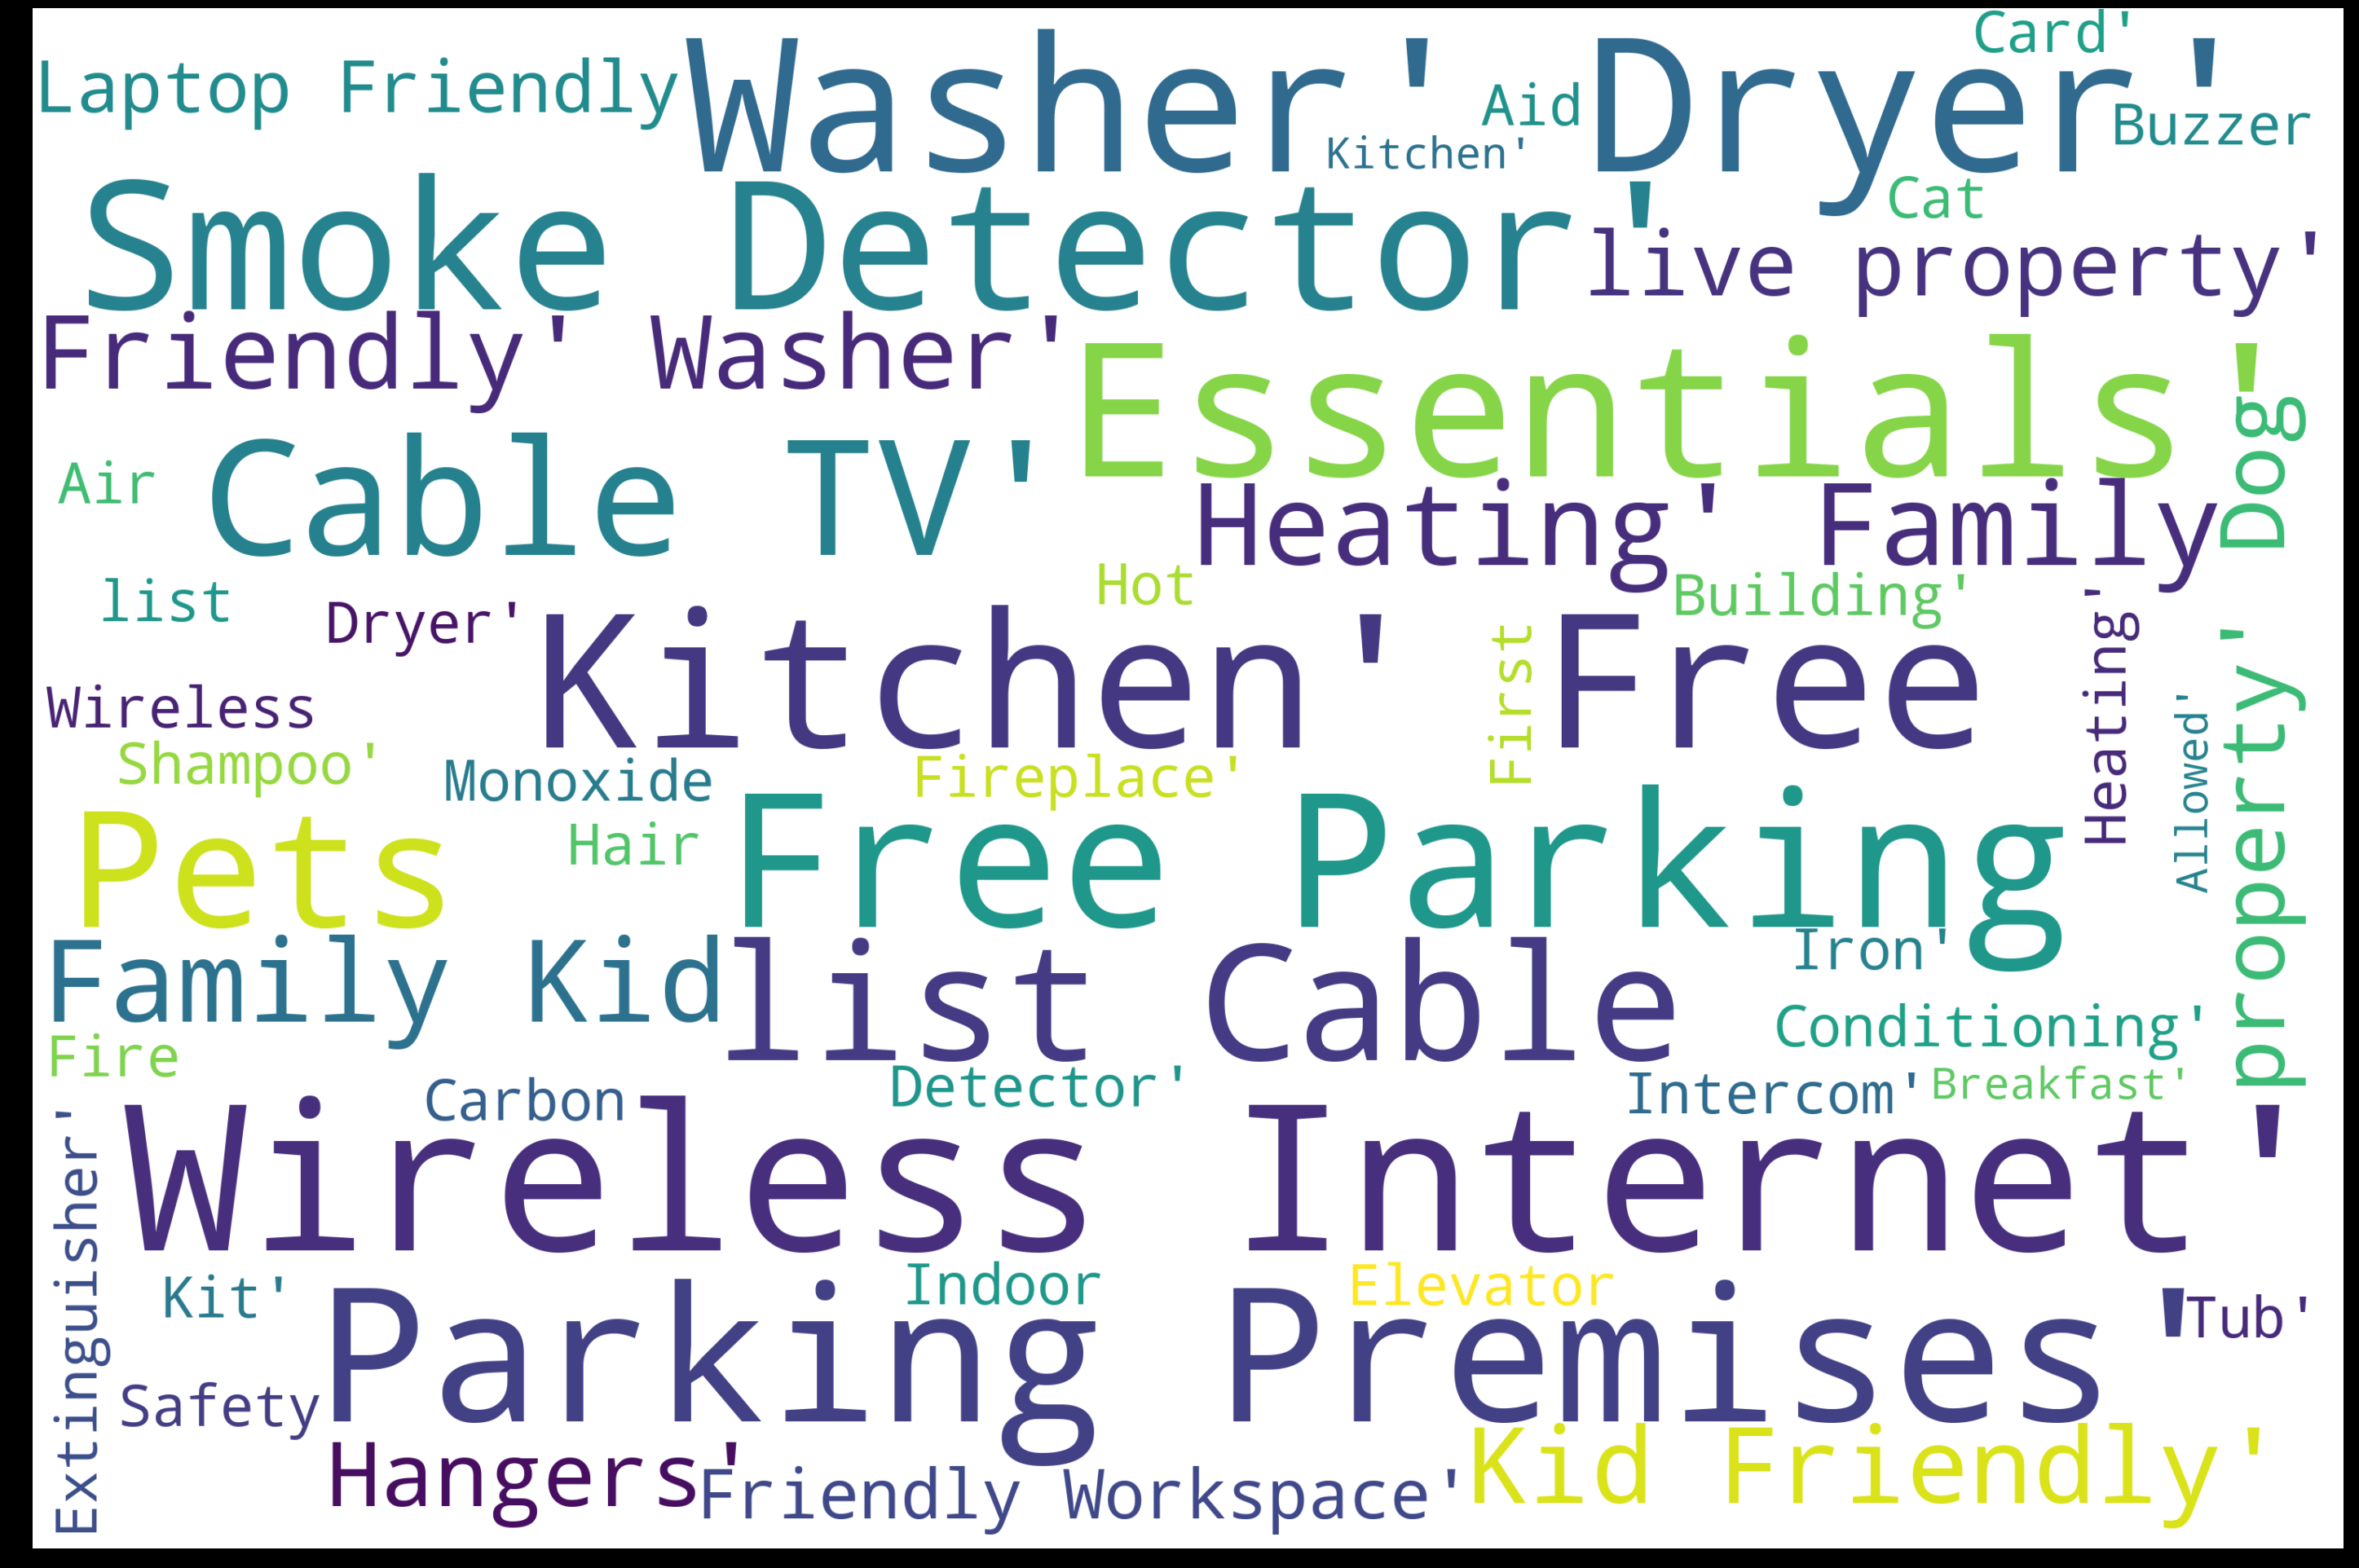

In [28]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white').generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [29]:
amenities_dict = {}
for i in range(len(text)):
    for j in range(len(text[i])):
        if text[i][j] in amenities_dict.keys():
            amenities_dict[text[i][j]] += 1
        else:
            amenities_dict[text[i][j]] = 1

In [30]:
amenities_s = pd.Series(amenities_dict).sort_values()

[Text(0, 0, 'Washer / Dryer'),
 Text(0, 0, ''),
 Text(0, 0, 'Other pet(s)'),
 Text(0, 0, 'Smoking Allowed'),
 Text(0, 0, 'Doorman'),
 Text(0, 0, 'Lock on Bedroom Door'),
 Text(0, 0, 'Pool'),
 Text(0, 0, 'Suitable for Events'),
 Text(0, 0, 'Breakfast'),
 Text(0, 0, 'Wheelchair Accessible'),
 Text(0, 0, 'Hot Tub'),
 Text(0, 0, 'Cat(s)'),
 Text(0, 0, 'Gym'),
 Text(0, 0, 'Pets Allowed'),
 Text(0, 0, 'Dog(s)'),
 Text(0, 0, 'Buzzer/Wireless Intercom'),
 Text(0, 0, '24-Hour Check-in'),
 Text(0, 0, 'Air Conditioning'),
 Text(0, 0, 'Safety Card'),
 Text(0, 0, 'Iron'),
 Text(0, 0, 'Laptop Friendly Workspace'),
 Text(0, 0, 'Hair Dryer'),
 Text(0, 0, 'Elevator in Building'),
 Text(0, 0, 'Hangers'),
 Text(0, 0, 'Pets live on this property'),
 Text(0, 0, 'Indoor Fireplace'),
 Text(0, 0, 'Cable TV'),
 Text(0, 0, 'First Aid Kit'),
 Text(0, 0, 'Family/Kid Friendly'),
 Text(0, 0, 'Free Parking on Premises'),
 Text(0, 0, 'Fire Extinguisher'),
 Text(0, 0, 'Carbon Monoxide Detector'),
 Text(0, 0, 'Shampoo'

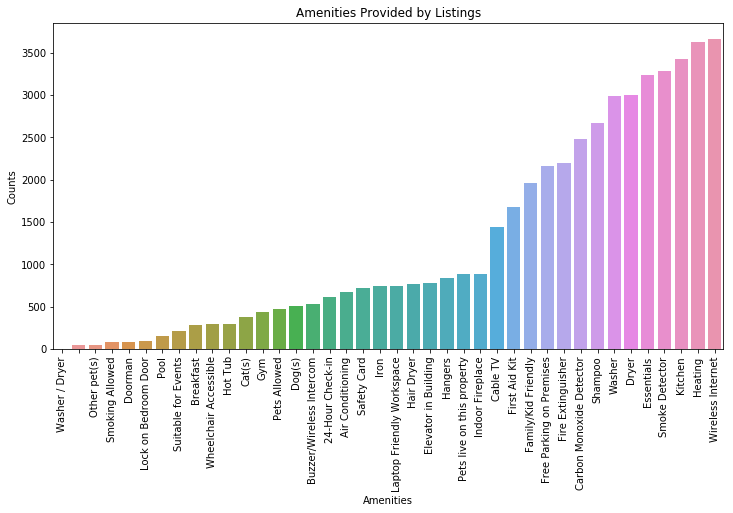

In [79]:
plt.figure(figsize = (12,6))
g = sns.barplot(x = amenities_s.index, y = amenities_s.values)
g.set(xlabel = 'Amenities', ylabel = 'Counts', title = 'Amenities Provided by Listings')
g.set_xticklabels([i for i in g.get_xticklabels()], rotation=90)

# Availability Analysis

In [32]:
listing_calendar_avail_agg = {'available':'mean'}
listing_calendar_avail_df = groupby_agg(listing_calendar_df, 'date', listing_calendar_avail_agg)

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Seattle Airbnb Availability(%) Trend')

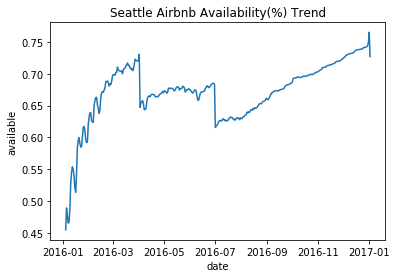

In [33]:
g = sns.lineplot(x = 'date', y = 'available', data = listing_calendar_avail_df)
g.set_title("Seattle Airbnb Availability(%) Trend")

The available listings kept increasing from January to April and the needs of AirBnB house increasing til July. And the needs of house/apt will decreasing.

In [34]:
listing_calendar_room_avail_gb = ['date', 'room_type']
listing_calendar_room_avail_agg = {'available':['count','sum', 'mean']}
listing_calendar_room_avail_df = groupby_agg(listing_calendar_df, listing_calendar_room_avail_gb, listing_calendar_room_avail_agg)

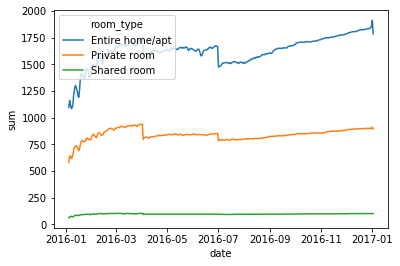

In [35]:
sns.lineplot(x=listing_calendar_room_avail_df['date'], y=listing_calendar_room_avail_df['available']['sum'], hue=listing_calendar_room_avail_df['room_type'])

The trend above shows the entire home/apt room and private room types share the same trends as the total available trends in the market. But the demand trends of the shared room consistently low. And this room type doesn't have many availibilities in the market. Based on this trend, we can't tell if the shared room type is more popular in the Seattle market or the listings of this type is lower than other two. Need to further analysis.

Text(0.5, 1.0, 'Seattle Airbnb Availability(%) by Room Type')

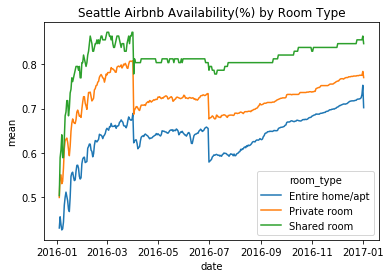

In [36]:
g = sns.lineplot(x=listing_calendar_room_avail_df['date'], y=listing_calendar_room_avail_df['available']['mean'], hue=listing_calendar_room_avail_df['room_type'])
g.set_title("Seattle Airbnb Availability(%) by Room Type")

The total listings of Shared Room type is lower than other two types. After check the available percentage of three types. All of them have the same trends. And the Shared Room type is the least popular in the Seattle market.While the most people like the entire home/apt types.

In [37]:
listing_calendar_city_avail_gb = ['date','city']
listing_calendar_city_avail_agg = {'available':['count', 'sum', 'mean']}
listing_calendar_city_avail_df = groupby_agg(listing_calendar_df, listing_calendar_city_avail_gb, listing_calendar_city_avail_agg)

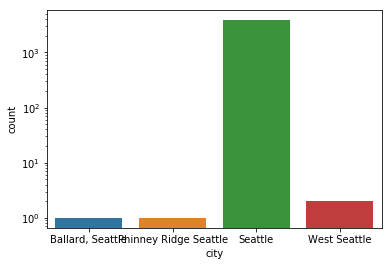

In [39]:
g = sns.barplot(x = listing_calendar_city_avail_df['city'], y = listing_calendar_city_avail_df['available']['count'])
g.set_yscale("log")

The city of Seattle has much more listings than other cities. However, we may need to consider the situation that some listings are in other cities, such as West Seattle, but put Seattle as the city on the listings. But it still worthes to check the listings by city.

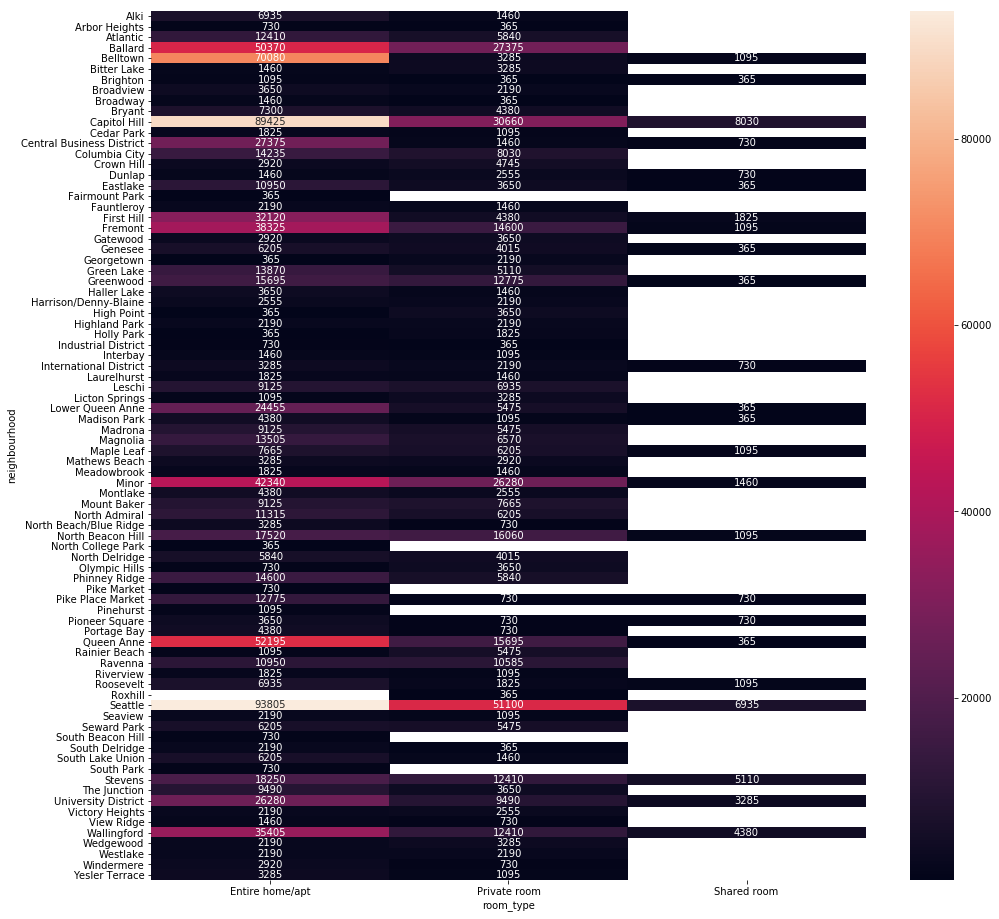

In [40]:
plt.figure(figsize=(16, 16))
listing_calendar_city_avail_df_v2 = listing_calendar_df.pivot_table(index='neighbourhood', columns='room_type', values='available', aggfunc=len)
sns.heatmap(listing_calendar_city_avail_df_v2, annot=True, fmt=".0f")

Seattle has the most lisings of entire home/apt and private room types. The community of capitol hill,bell town and ballard had a lot listings as well. Overall, a visitor had more choices if they plan to rent a home or have a private room in these areas. Capitol hill community also provided a lot options of shared room.

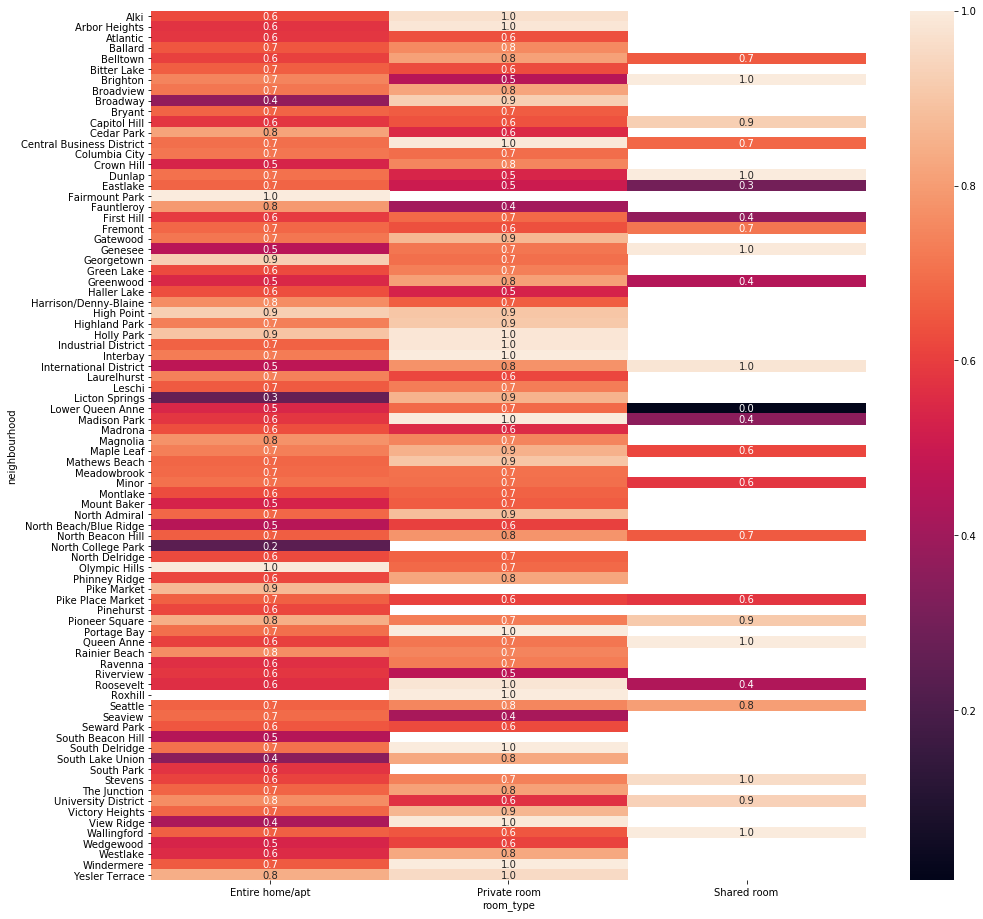

In [41]:
plt.figure(figsize=(16, 16))
listing_calendar_city_avail_df_v2 = listing_calendar_df.pivot_table(index='neighbourhood', columns='room_type', values='available', aggfunc=np.mean)
sns.heatmap(listing_calendar_city_avail_df_v2, annot=True, fmt=".1f")

Compare with the supplies and demands. It is difficult to find entire home/apt in north college part and licton springs. While it's the most difficult task to find a shared room in the lower queen anne and eastlake communities.

AirBnB has a feature called Superhost. According to AirBnB, the superhost "are experienced hosts who provide a shining example for other hosts, and extraordinary experiences for their guests." Hosts would become Superhosts if they meet certain criteria. These criteria including communication, commitment, guest satisfaction, and experience. Would superhosts feature have any impact on the availability?

In [42]:
listing_calendar_superhost_avail_gb = ['date', 'host_is_superhost']
listing_calendar_superhost_avail_agg = {'available':['sum', 'count', 'mean']}
listing_calendar_superhost_avail_df = groupby_agg(listing_calendar_df, listing_calendar_superhost_avail_gb, listing_calendar_superhost_avail_agg)

Text(0.5, 1.0, 'Seattle Airbnb Availability(%) of Superhosts vs. Non-Superhosts')

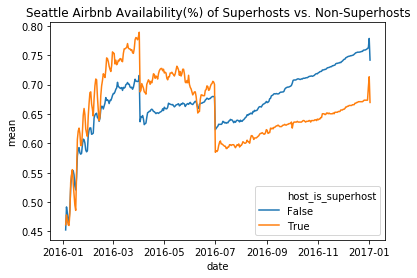

In [43]:
g = sns.lineplot(x = listing_calendar_superhost_avail_df['date'], y = listing_calendar_superhost_avail_df['available']['mean'], hue = listing_calendar_superhost_avail_df['host_is_superhost'])
g.set_title("Seattle Airbnb Availability(%) of Superhosts vs. Non-Superhosts")

Based on the trends above. There is no significant availability difference between superhosts and non-superhosts before 2016-07. Actually, the percentage of listings availbility of superhost is higher than the non-superhosts. Which means, the listings of superhosts had more available dates than the listings of non-superhosts. The reason is unknown from the trends above. However, the listings of superhost became popular in the market after 2016-07.

In [44]:
listing_calendar_superhost_avail_gb_v2 = 'host_is_superhost'
listing_calendar_superhost_avail_agg_v2 = {'available':'mean'}
listing_calendar_superhost_avail_df_v2 = groupby_agg(listing_calendar_df, listing_calendar_superhost_avail_gb_v2, listing_calendar_superhost_avail_agg_v2)
listing_calendar_superhost_avail_df_v2

,host_is_superhost,available
0,False,0.673151
1,True,0.660682


Overall the average availability between superhosts' listings and non-superhosts' are close.

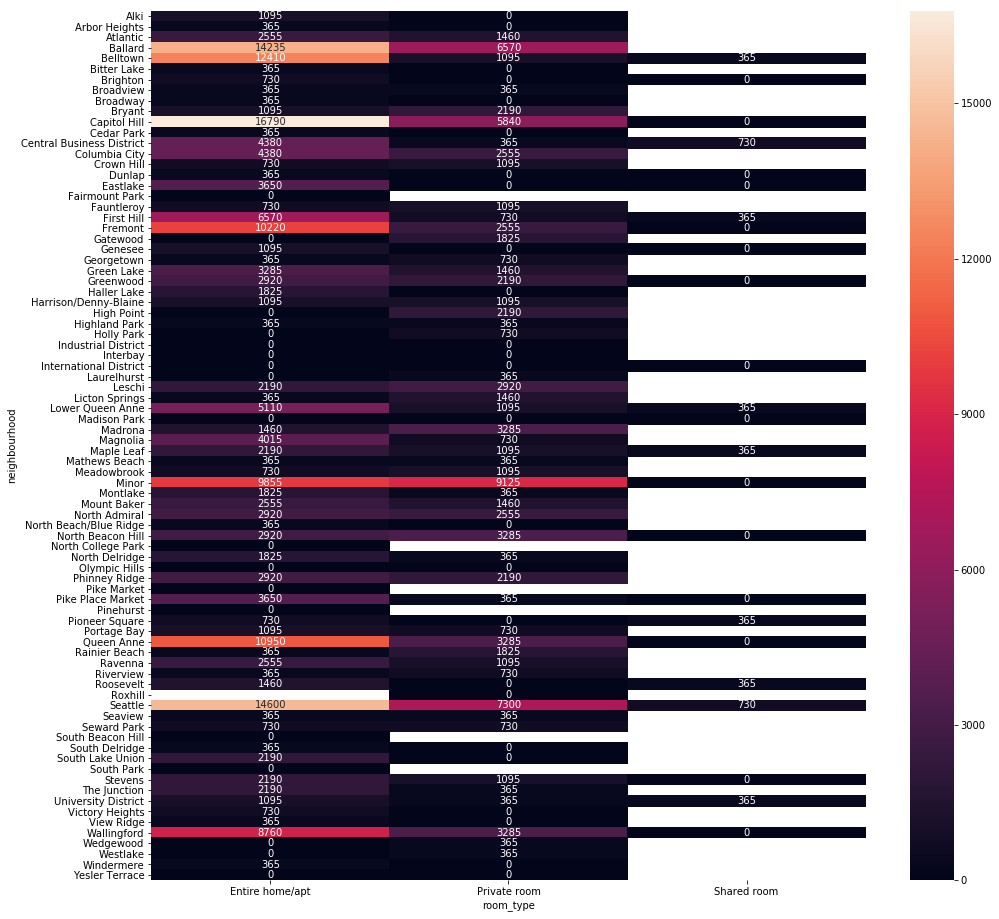

In [45]:
plt.figure(figsize=(16, 16))
listing_calendar_superhost_avail_df_v3 = listing_calendar_df.pivot_table(index='neighbourhood', columns='room_type', values='host_is_superhost', aggfunc=np.sum)
sns.heatmap(listing_calendar_superhost_avail_df_v3, annot=True, fmt=".0f")

Based on the heatmap above. It seems superhosts provide more entire home/apt and private rooms in the Seattle market.

In [46]:
listing_calendar_superhost_avail_gb_v4 = ['host_is_superhost', 'room_type']
listing_calendar_superhost_avail_agg_v4 = {'available':'mean'}
listing_calendar_superhost_avail_df_v4 = groupby_agg(listing_calendar_df, listing_calendar_superhost_avail_gb_v4, listing_calendar_superhost_avail_agg_v4)
listing_calendar_superhost_avail_df_v4.sort_values('room_type')

,host_is_superhost,room_type,available
0,False,Entire home/apt,0.638797
3,True,Entire home/apt,0.642775
1,False,Private room,0.730032
4,True,Private room,0.702077
2,False,Shared room,0.839080
5,True,Shared room,0.572354


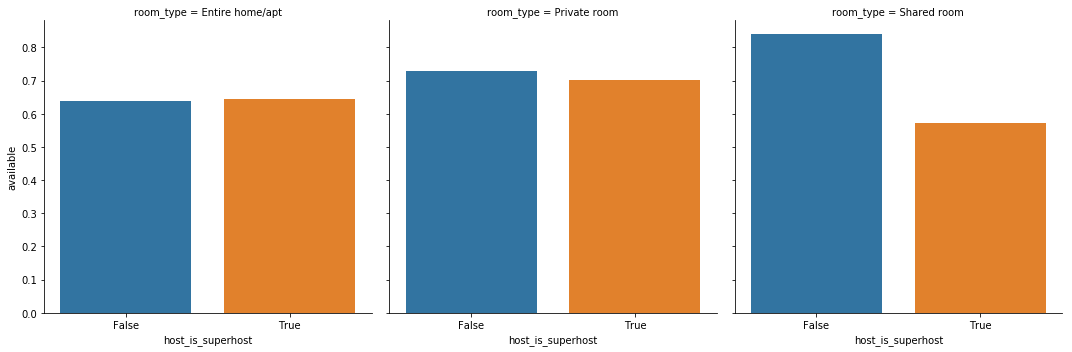

In [47]:
g = sns.catplot(x = 'host_is_superhost', y = 'available', data = listing_calendar_superhost_avail_df_v4, kind = 'bar', col = 'room_type')

Although the popularity of listings between superhosts and non-superhosts has no significant differences. The shared room type from the superhosts is more popular than the listings from the non-superhosts.

In [48]:
listing_calendar_superhost_avail_gb_v5 = ['date', 'host_is_superhost', 'room_type']
listing_calendar_superhost_avail_agg_v5 = {'available':'mean'}
listing_calendar_superhost_avail_df_v5 = groupby_agg(listing_calendar_df, listing_calendar_superhost_avail_gb_v5, listing_calendar_superhost_avail_agg_v5)
listing_calendar_superhost_avail_df_v5.sort_values('room_type')

,date,host_is_superhost,room_type,available
0,2016-01-04,False,Entire home/apt,0.427300
867,2016-05-27,True,Entire home/apt,0.701349
870,2016-05-28,False,Entire home/apt,0.631553
873,2016-05-28,True,Entire home/apt,0.709056
1896,2016-11-15,False,Entire home/apt,0.708704
...,...,...,...,...
1085,2016-07-02,True,Shared room,0.545455
1082,2016-07-02,False,Shared room,0.820755
1079,2016-07-01,True,Shared room,0.545455
1100,2016-07-05,False,Shared room,0.811321


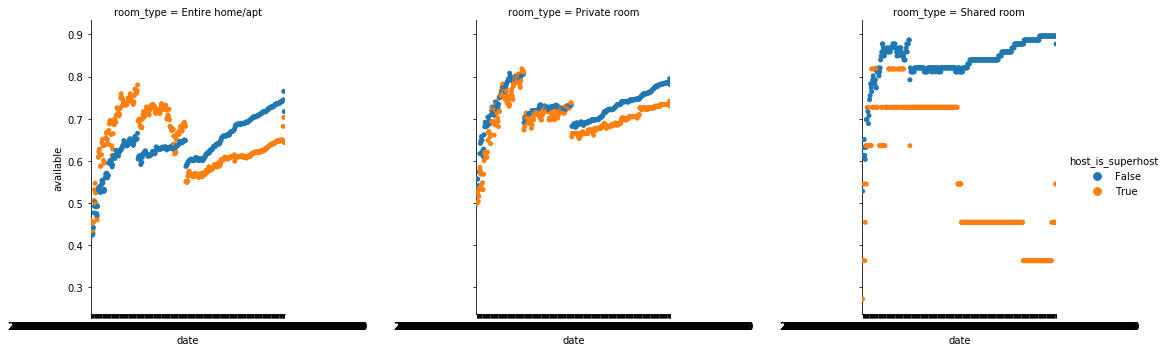

In [49]:
g = sns.catplot(x = 'date', y = 'available', hue = 'host_is_superhost', data = listing_calendar_superhost_avail_df_v5, col = 'room_type')

The superhosts is a great feature that a visitor will have more chances to gain better experiences. I assume the listings from the superhosts will be more popular than these of non-superhosts. However, the results doesn't approve my assumption. Will be any other factor impact the decisions of visitors when they choose prior to finding a great host?

# Price Analysis

[Text(0, 0.5, 'Frequency'), Text(0.5, 1.0, 'Distribution of Price')]

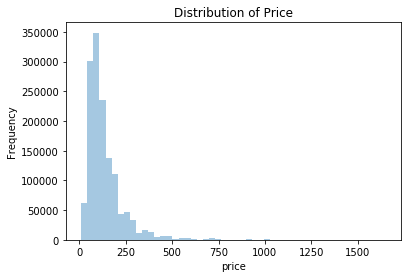

In [50]:
sns.distplot(listing_calendar_df.price, kde = False).set(ylabel = 'Frequency', title = 'Distribution of Price')

The distribution of price is left skewed and the most listings are inbetween the range 0-250

Text(0.5, 1.0, 'Seattle Airbnb Avg Price Trends')

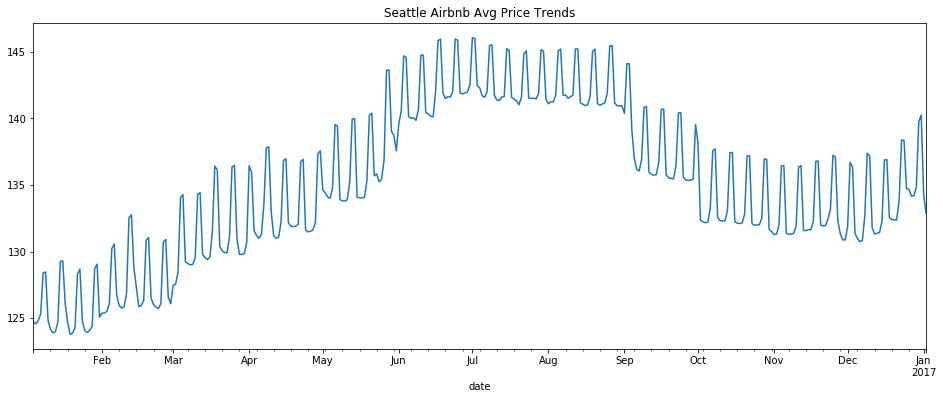

In [51]:
plt.figure(figsize=(16, 6))
g = listing_calendar_df.groupby('date').price.mean().plot()
g.set_title("Seattle Airbnb Avg Price Trends")

The price trend follows the needs of house available. The needs of house were high from april and consisted through the summer time. 

In [52]:
(listing_calendar_df.loc[(listing_calendar_df.date >= '2016-12-31'), 'price'].mean() - listing_calendar_df.loc[(listing_calendar_df.date <= '2016-02-01'), 'price'].mean())/listing_calendar_df.loc[(listing_calendar_df.date <= '2016-02-01'), 'price'].mean()

0.08019125317922636

The average price in January 2017 has increased 8% compared to last year.

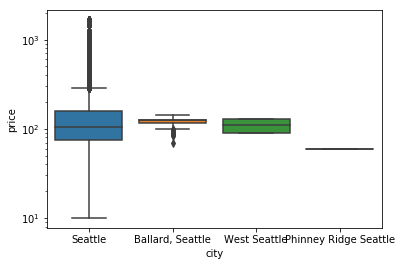

In [53]:
g = sns.boxplot(x = 'city', y = 'price', data = listing_calendar_df)
g.set_yscale("log")

The listings in Seattle had vary prices. And the prices of the listings of the other cities are in the range of 0-250 consistently. Ballard has some lower price listings. And the Ridge Seattle has the lowest price range.

In [54]:
listing_calendar_room_price_gb = ['date', 'room_type']
listing_calendar_room_price_agg = {'price':'mean'}
listing_calendar_room_price_df = groupby_agg(listing_calendar_df, listing_calendar_room_price_gb, listing_calendar_room_price_agg)

In [55]:
listing_calendar_room_price_df.head()

,date,room_type,price
0,2016-01-04,Entire home/apt,151.509642
1,2016-01-04,Private room,73.808621
2,2016-01-04,Shared room,47.256410
3,2016-01-05,Entire home/apt,151.436049
4,2016-01-05,Private room,73.518966


Text(0.5, 1.0, 'Seattle Airbnb Avg Price Trends by Room Type')

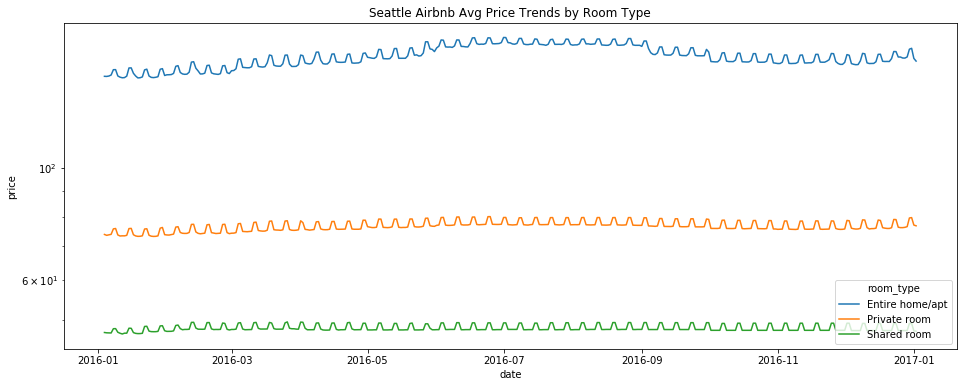

In [56]:
plt.figure(figsize=(16, 6))
g = sns.lineplot(x = 'date', y = 'price', hue = 'room_type', data = listing_calendar_room_price_df)
g.set_yscale("log")
plt.legend(loc='lower right')
g.set_title("Seattle Airbnb Avg Price Trends by Room Type")

It makes sense that more private spaces would have higher price.

In [58]:
listing_calendar_superhost_price_gb = ['date', 'host_is_superhost']
listing_calendar_superhost_price_agg = {'price':'mean'}
listing_calendar_superhost_price_df = groupby_agg(listing_calendar_df, listing_calendar_superhost_price_gb, listing_calendar_superhost_price_agg)

Text(0.5, 1.0, 'Seattle Airbnb Listing Price Trend by Host Type')

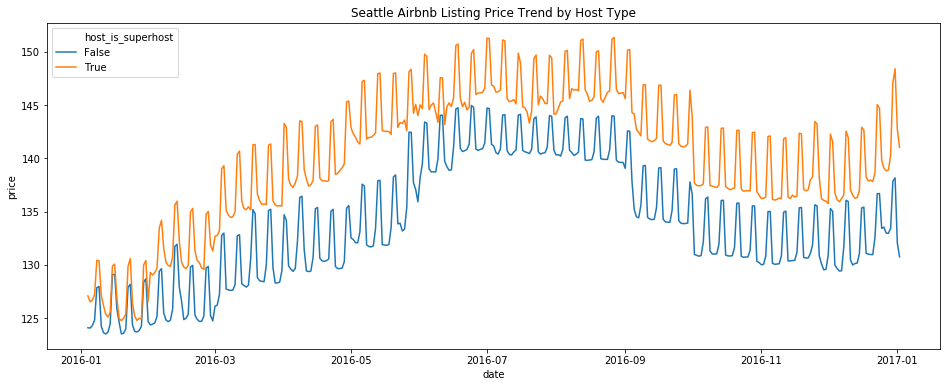

In [60]:
plt.figure(figsize=(16, 6))
g = sns.lineplot(x = 'date', y = 'price', hue = 'host_is_superhost', data = listing_calendar_superhost_price_df)
g.set_title("Seattle Airbnb Listing Price Trend by Host Type")

The average price of listings of superhost is higher than the ones of non super host. But the availability doesn't have big differences. Can we assume the visitors may pricing-sensitive. And many of them may choose price prior to the better service.

In [61]:
listing_calendar_superhost_price_gb_v2 = ['host_is_superhost','room_type']
listing_calendar_superhost_price_agg_v2 = {'price':'mean'}
listing_calendar_superhost_price_df_v2 = groupby_agg(listing_calendar_df, listing_calendar_superhost_price_gb_v2, listing_calendar_superhost_price_agg_v2)

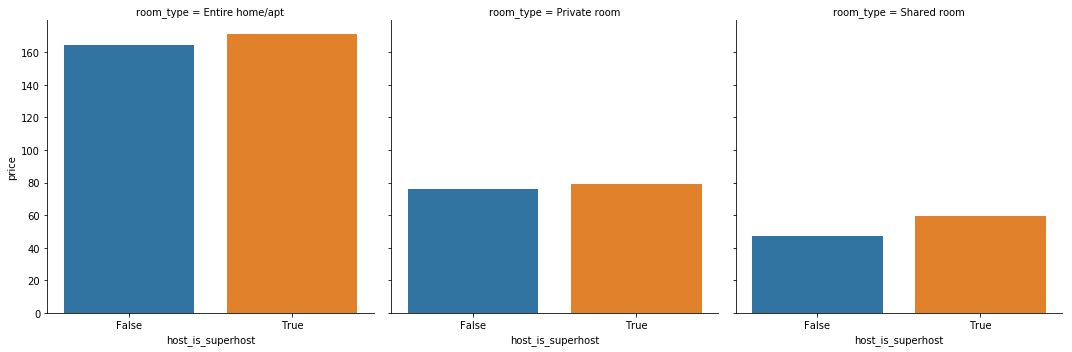

In [62]:
g = sns.catplot(x = 'host_is_superhost', y = 'price', data = listing_calendar_superhost_price_df_v2, kind = 'bar', col = 'room_type')

In [63]:
listing_calendar_superhost_price_gb_v3 = ['date','host_is_superhost','room_type']
listing_calendar_superhost_price_agg_v3 = {'price':'mean'}
listing_calendar_superhost_price_df_v3 = groupby_agg(listing_calendar_df, listing_calendar_superhost_price_gb_v3, listing_calendar_superhost_price_agg_v3)

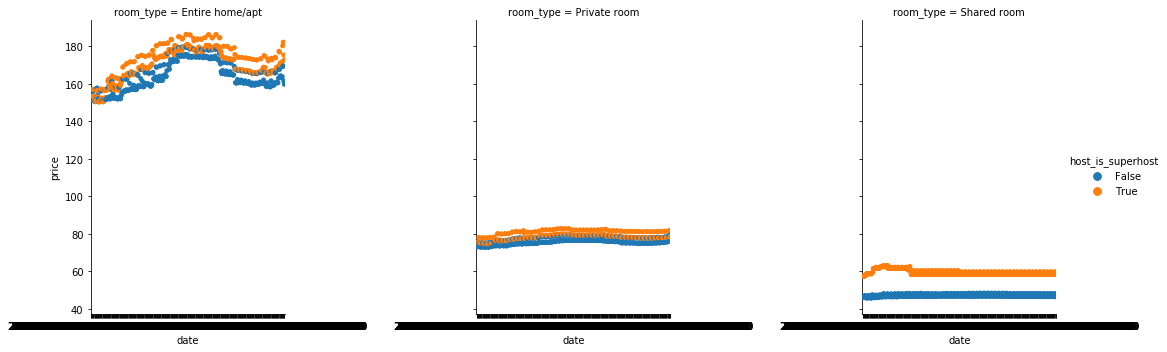

In [64]:
g = sns.catplot(x = 'date', y = 'price', hue = 'host_is_superhost', data = listing_calendar_superhost_price_df_v3, col = 'room_type')

Based on the trends above. The prices of private room between superhosts and non-superhosts are close. While the prices of the entire home/apt and shared rooms, the listings of the superhosts were more expensive than these of non-superhosts.

# Price vs Availability

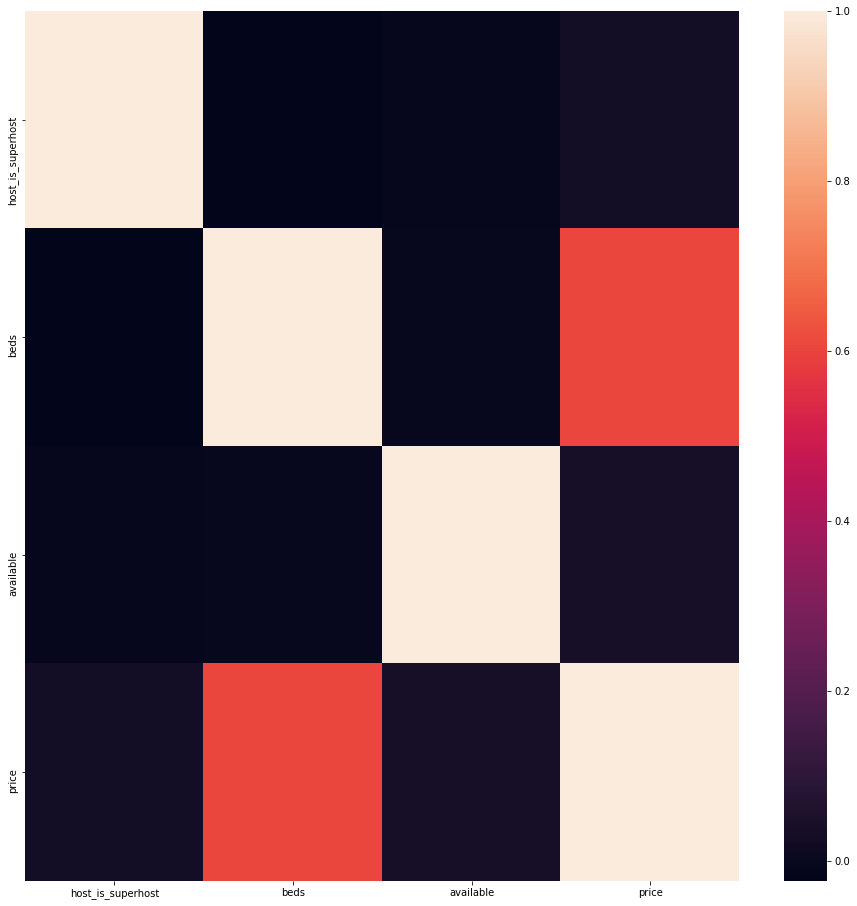

In [65]:
plt.figure(figsize = (16,16))
g = sns.heatmap(listing_calendar_df[['host_is_superhost', 'beds', 'available', 'price']].corr())

In [66]:
listing_calendar_df[['host_is_superhost', 'beds', 'available', 'price']].corr()

,host_is_superhost,beds,available,price
host_is_superhost,1.000000,-0.023394,-0.010686,0.025030
beds,-0.023394,1.000000,-0.007339,0.605855
available,-0.010686,-0.007339,1.000000,0.039789
price,0.025030,0.605855,0.039789,1.000000


Interestingly, the price and available didn't have strong relationship

# Prediction Model

In [68]:
listing_calendar_df_lm = listing_calendar_df[['price', 'available', 'date', 'city', 'neighbourhood', 'host_since', 'host_is_superhost', 'room_type',
                                             'bed_type', 'beds', 'bedrooms', 'bathrooms'
                                            , 'minimum_nights', 'cancellation_policy', 'instant_bookable']]

In [69]:
listing_calendar_df_lm['host_since_days'] = (listing_calendar_df_lm['date'] - listing_calendar_df_lm['host_since']).astype('timedelta64[D]')

In [70]:
#need to convert the date into category
listing_calendar_df_lm['month'] = pd.DatetimeIndex(listing_calendar_df_lm['date']).month
listing_calendar_df_lm['month_cat'] = listing_calendar_df_lm['month'].astype('category')

In [71]:
listing_calendar_df_lm['month_cat'].dtype

CategoricalDtype(categories=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], ordered=False)

In [72]:
listing_calendar_df_lm = pd.get_dummies(listing_calendar_df_lm[['price', 'available', 'month_cat', 'city', 'neighbourhood', 'host_since_days', 'host_is_superhost', 'room_type',
                                             'bed_type', 'beds', 'bedrooms', 'bathrooms'
                                            , 'minimum_nights', 'cancellation_policy', 'instant_bookable']], prefix_sep='_')

In [73]:
listing_calendar_df_lm.head()

,price,available,host_since_days,host_is_superhost,beds,bedrooms,bathrooms,minimum_nights,instant_bookable,month_cat_1,...,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict
0,85.0,True,1607.0,False,1.0,1.0,1.0,1,False,1,...,0,0,0,0,0,0,1,0,1,0
1,85.0,True,1608.0,False,1.0,1.0,1.0,1,False,1,...,0,0,0,0,0,0,1,0,1,0
2,85.0,False,1609.0,False,1.0,1.0,1.0,1,False,1,...,0,0,0,0,0,0,1,0,1,0
3,85.0,False,1610.0,False,1.0,1.0,1.0,1,False,1,...,0,0,0,0,0,0,1,0,1,0
4,85.0,False,1611.0,False,1.0,1.0,1.0,1,False,1,...,0,0,0,0,0,0,1,0,1,0


In [74]:
def clean_fit_linear_mod(df, response_col, test_size=.3, rand_state=123):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''

    X = df.drop(response_col, axis = 1)
    y = df[response_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = rand_state)
    lm_model = LinearRegression(normalize = True)
    lm_model.fit(X_train, y_train)
    y_train_pred = lm_model.predict(X_train)
    y_test_pred = lm_model.predict(X_test)
    train_score = r2_score(y_train, y_train_pred)
    test_score = r2_score(y_test, y_test_pred)
    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test

In [75]:
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = clean_fit_linear_mod(listing_calendar_df_lm, 'price')

In [76]:
print(test_score, train_score)

0.5921062977120043 0.5922151561526257
